In [2]:
# Basic libraries
import pandas as pd
import numpy as np

# For text preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# For BERT
from transformers import BertTokenizer, TFBertForSequenceClassification, TFAlbertForSequenceClassification, AlbertTokenizer, AlbertModel, DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf


In [3]:
# Load your dataset (ensure it's in the correct format: CSV with 'text' and 'label' columns)
df = pd.read_csv('./data/labeled_data.csv')

print(len(df))
# df = df[0:15000]

# Check for missing values
print(df.isnull().sum())

# Basic exploration of the dataset
print(df['class'].value_counts())
print(df.head())




24783
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64
1    19190
2     4163
0     1430
Name: class, dtype: int64
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The

In [4]:
# Split dataset into training and testing sets (80-20 split)

df = df.rename(columns={
    'tweet': 'Content',
    'class': 'Label'
})

df = df[['Content', 'Label']]

print(df)

X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label'])

# For traditional models: use TF-IDF to convert text into feature vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features for performance
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)



                                                 Content  Label
0      !!! RT @mayasolovely: As a woman you shouldn't...      2
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1
...                                                  ...    ...
24778  you's a muthaf***in lie &#8220;@LifeAsKing: @2...      1
24779  you've gone and broke the wrong heart baby, an...      2
24780  young buck wanna eat!!.. dat nigguh like I ain...      1
24781              youu got wild bitches tellin you lies      1
24782  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...      2

[24783 rows x 2 columns]


In [5]:
# Initialize and train the Multinomial Naive Bayes model
nb_model_mn = MultinomialNB()
nb_model_mn.fit(X_train_tfidf, y_train)

# Make predictions
nb_predictions_mn = nb_model_mn.predict(X_test_tfidf)

# Evaluate model performance
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_predictions_mn))
print(classification_report(y_test, nb_predictions_mn))


Naive Bayes Accuracy: 0.8269114383699818
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       286
           1       0.82      0.99      0.90      3838
           2       0.89      0.34      0.49       833

    accuracy                           0.83      4957
   macro avg       0.90      0.45      0.47      4957
weighted avg       0.84      0.83      0.78      4957



In [11]:
# Initialize and train the Support Vector Machine model
svm_model = SVC(kernel='linear')  # Linear kernel is commonly used for text classification
svm_model.fit(X_train_tfidf, y_train)

# Make predictions
svm_predictions = svm_model.predict(X_test_tfidf)

# Evaluate model performance
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))


SVM Accuracy: 0.9074036715755497
              precision    recall  f1-score   support

           0       0.62      0.13      0.21       286
           1       0.92      0.97      0.94      3838
           2       0.85      0.91      0.88       833

    accuracy                           0.91      4957
   macro avg       0.80      0.67      0.68      4957
weighted avg       0.89      0.91      0.89      4957



In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer


# Initialize the BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the text data for BERT
def tokenize_text(text, max_length=128):
    return tokenizer(text.tolist(), 
                     padding=True, 
                     truncation=True, 
                     max_length=max_length, 
                     return_tensors='tf')

# Tokenize the training and testing sets
train_encodings = tokenize_text(X_train)
test_encodings = tokenize_text(X_test)


In [7]:
import tensorflow as tf

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train.values)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test.values)).batch(32)


from transformers import TFBertForSequenceClassification, create_optimizer

# Load pre-trained BERT model for sequence classification (with 3 output labels)
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Number of training steps
batch_size = 32
num_train_steps = len(X_train) // batch_size * 1  # Assuming 3 epochs

num_warmup_steps = int(0.1 * num_train_steps)

# Create the AdamW optimizer
optimizer, lr_schedule = create_optimizer(init_lr=2e-5, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps)

# Compile the model using AdamW optimizer
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [8]:
from sklearn.metrics import f1_score
import numpy as np

# Define a custom callback to calculate F1-score after each epoch
# class F1ScoreCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data):
#         super(F1ScoreCallback, self).__init__()
#         self.validation_data = validation_data

#     def on_epoch_end(self, epoch, logs=None):
#         val_data = self.validation_data
#         val_x = val_data[0]
#         val_y = val_data[1]
#         predictions = np.argmax(self.model.predict(val_x), axis=-1)
#         f1 = f1_score(val_y, predictions, average='weighted')  # You can change the averaging method if needed
#         print(f"F1-Score for epoch {epoch + 1}: {f1:.4f}")


# Train the BERT model
# f1_callback = F1ScoreCallback(validation_data=(test_encodings, y_test.values))
model.fit(train_dataset, 
          validation_data=test_dataset, 
          epochs=3)  
 

Epoch 1/3


620/620 [==============================] - 5295s 9s/step - loss: 0.3435 - accuracy: 0.8824 - val_loss: 0.2412 - val_accuracy: 0.9131
Epoch 2/3
620/620 [==============================] - 5161s 8s/step - loss: 0.2301 - accuracy: 0.9181 - val_loss: 0.2412 - val_accuracy: 0.9131
Epoch 3/3
620/620 [==============================] - 5172s 8s/step - loss: 0.2304 - accuracy: 0.9175 - val_loss: 0.2412 - val_accuracy: 0.9131


In [9]:
from sklearn.metrics import classification_report
import numpy as np
# # Evaluate the BERT model on the test dataset
# loss, accuracy = model.evaluate(test_dataset)
# print(f"Test Accuracy: {accuracy:.4f}")

y_pred = []
y_true = []

for batch in test_dataset:
    inputs, labels = batch  # Unpack the batch into inputs and labels
    y_true.extend(labels)  # Convert labels to a list of numpy values for evaluation

    # Make predictions using the model
    outputs = model.predict(inputs)  # Alternatively, you may use model(inputs) if compatible
    preds = outputs.logits.argmax(axis=-1)  # Get the predicted classes
    y_pred.extend(preds)  # Convert predictions to a list of numpy values


# Calculate precision, recall, and F1 score
print(classification_report(y_true, y_pred, digits=4))

1/1 [==============================] - 4s 4s/step
              precision    recall  f1-score   support

           0     0.5763    0.1189    0.1971       286
           1     0.9325    0.9677    0.9498      3838
           2     0.8503    0.9340    0.8902       833

    accuracy                         0.9131      4957
   macro avg     0.7863    0.6735    0.6790      4957
weighted avg     0.8981    0.9131    0.8963      4957



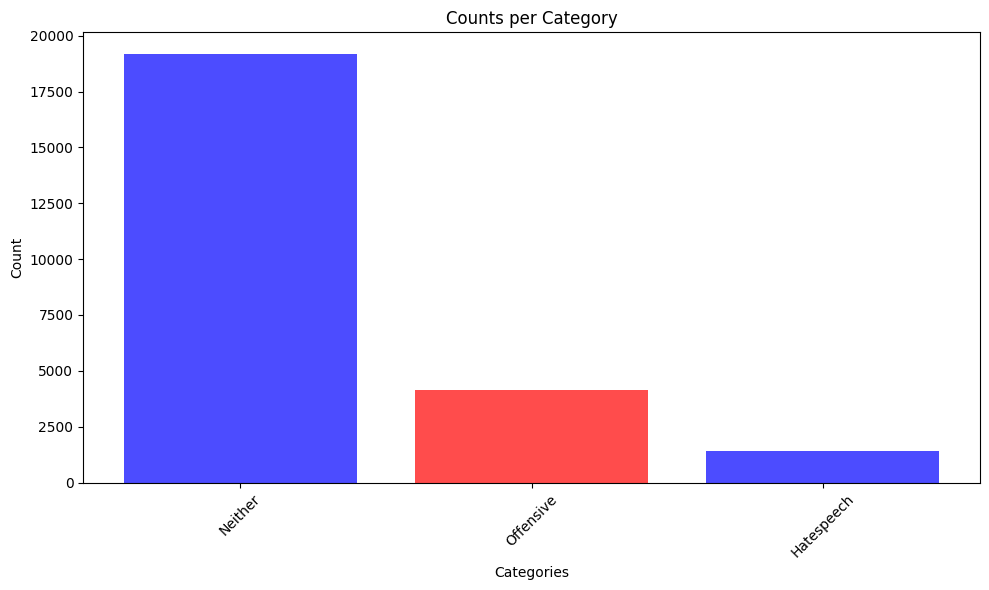

In [11]:
import matplotlib.pyplot as plt
columns = ["Label"] 

for column in columns:
        # Count the occurrences of each label in the column
        label_counts = df[column].value_counts()
        categories = ['Neither','Offensive','Hatespeech']  # Category names
        
        # Plot the bar chart
        plt.figure(figsize=(10, 6))
        plt.bar(categories, label_counts, color=['blue','red'], alpha=0.7)
        
        # Add chart title and labels
        plt.title(f'Counts per Category')
        plt.xlabel('Categories')
        plt.ylabel('Count')
        plt.xticks(categories, rotation=45)  # Customize x-axis labels to display category names
        
        # Show the plot
        plt.tight_layout()
        plt.show()